# Classification by clustering


In this example we're going to analyze the SDDS17 Stellar Classification Dataset (https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17/) using K-Means clustering in conjunction to Principal Component Analysis.

Each entry of the dataset is classified in one out of three categories: galaxies, stars ou quasars (quasi-stellar objects). The data features identifier (marked with '\*' in the list below) and physical measurements (such as redshift, photometric measurements and celestial coordinates).

*obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
alpha = Right Ascension angle (at J2000 epoch)

delta = Declination angle (at J2000 epoch)

u = Ultraviolet filter in the photometric system

g = Green filter in the photometric system

r = Red filter in the photometric system

i = Near Infrared filter in the photometric system

z = Infrared filter in the photometric system

*run_ID = Run Number used to identify the specific scan

*rereun_ID = Rerun Number to specify how the image was processed

*cam_col = Camera column to identify the scanline within the run

*field_ID = Field number to identify each field

*spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with 
the same spec_obj_ID must share the output class)

class = object class (galaxy, star or quasar object)

redshift = redshift value based on the increase in wavelength

*plate = plate ID, identifies each plate in SDSS

*MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken

fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

We'll start by applying PCA on the 8 features with physical meaning of the dataset. Then, we are going to test if the k-means method is efficient to distinguish the objects into their stellar classes.


In [1]:
# Import the packages

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the dataset

cols2read=['alpha','delta','u','g','r','i','z','redshift','obj_ID','class']
data_raw_df=pd.read_csv('star_classification.csv',usecols=cols2read,dtype={'obj_ID':str})
data_raw_df.set_index('obj_ID',inplace=True)
data_raw_df

,alpha,delta,u,g,r,i,z,class,redshift
obj_ID,,,,,,,,,
1237660961327743232,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1237664879951151360,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
1237660961330430208,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
1237663478724297984,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
1237680272041378048,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123
...,...,...,...,...,...,...,...,...,...
1237678879964201472,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000
1237679476408648192,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895
1237668298220634368,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366


In [3]:
# Standardize the data to mean 0 and variance 1

X0=data_raw_df.drop(columns='class').values
X=StandardScaler().fit_transform(X0)

X.mean(),X.std()

(-4.725109192804666e-17, 1.0000000000000002)

In [4]:
# Now we apply PCA to obtain a number of principal components that represent more than 95% of the variance

pca=PCA(n_components=0.95,svd_solver='full')
X_pca=pca.fit_transform(X)

In [5]:
# Variance ratio of the 5 PC's

pca.explained_variance_ratio_

array([0.37797983, 0.28362062, 0.14261839, 0.10769035, 0.08348138])

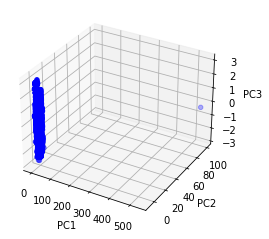

In [6]:
# Plot of the first 3 PC's

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c='b', marker='o')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

fig.savefig('images/PCA_3D_outlier.png')
plt.show()

Clearly, the dataset has at least one outlier. We can identify it in the plot above as the single point far away from the cloud.

In [7]:
# Identifying the outlier

data_raw_df.iloc[X_pca[:,0]>200]

,alpha,delta,u,g,r,i,z,class,redshift
obj_ID,,,,,,,,,
1237648703521095936,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,STAR,0.000089


In [8]:
# We must remove the outlier from the dataset and repeat the PCA analysis

data_cleaned_df=data_raw_df.iloc[X_pca[:,0]<200]

X_cleaned=StandardScaler().fit_transform(data_cleaned_df.drop(columns='class').values)

pca_cleaned=PCA(n_components=0.95,svd_solver='full')
X_pca_cleaned=pca_cleaned.fit_transform(X_cleaned)

col_names=['feature'+str(i+1) for i in range(X_pca_cleaned.shape[1])]
pca_df=pd.DataFrame(data=X_pca_cleaned,columns=col_names)
pca_df.index=data_cleaned_df.index
pca_df['class']=data_cleaned_df['class']
pca_df

,feature1,feature2,feature3,feature4,feature5,class
obj_ID,,,,,,
1237660961327743232,-0.884241,-0.046795,-0.326381,-0.737343,0.577395,GALAXY
1237664879951151360,-2.961830,0.000289,-0.151040,-0.566810,-0.306433,GALAXY
1237660961330430208,-1.333677,0.079897,-0.631246,-0.893152,0.887738,GALAXY
1237663478724297984,-1.773637,0.299528,-0.658940,1.952619,-0.100255,GALAXY
1237680272041378048,3.650692,1.072276,-0.526847,1.235087,0.320971,GALAXY
...,...,...,...,...,...,...
1237678879964201472,-1.979555,-2.058061,-0.370558,-0.238036,-1.269688,GALAXY
1237679476408648192,-0.975608,-1.272342,0.023634,-0.995348,-0.129268,GALAXY
1237668298220634368,1.661993,-0.022759,-0.478326,0.514658,0.056985,GALAXY


In [9]:
# Save PCA results

pca_df.to_csv('PCA_results.csv')

In [10]:
# Variance ratio of the new PC's

pca.explained_variance_ratio_

array([0.37797983, 0.28362062, 0.14261839, 0.10769035, 0.08348138])

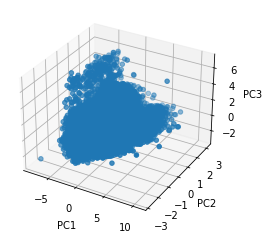

In [11]:
# Plot of the new PC's

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca_cleaned[:,0], X_pca_cleaned[:,1], X_pca_cleaned[:,2], '.b')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

fig.savefig('images/PCA_3D_cleaned.png')
plt.show()

By removing the outlier, we can now study the relation of the principal components to the type of object they represent. The best way to do this is by plotting the data.

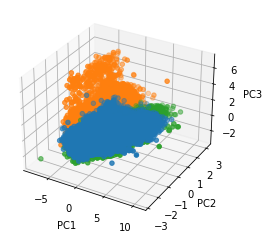

In [12]:
# 3D plot of the first 3 PC's

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Galaxies
ax.scatter(X_pca_cleaned[pca_df['class']=='GALAXY'][:,0],
           X_pca_cleaned[pca_df['class']=='GALAXY'][:,1], 
           X_pca_cleaned[:,2][pca_df['class']=='GALAXY'], '.b')
# QSOs
ax.scatter(X_pca_cleaned[pca_df['class']=='QSO'][:,0],
           X_pca_cleaned[pca_df['class']=='QSO'][:,1], 
           X_pca_cleaned[:,2][pca_df['class']=='QSO'], '.r')
# Stars
ax.scatter(X_pca_cleaned[pca_df['class']=='STAR'][:,0],
           X_pca_cleaned[pca_df['class']=='STAR'][:,1], 
           X_pca_cleaned[:,2][pca_df['class']=='STAR'], '.g')

# Set labels for each axis
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

fig.savefig('images/PCA_3D_cleaned_classes.png')

# Show the plot
plt.show()


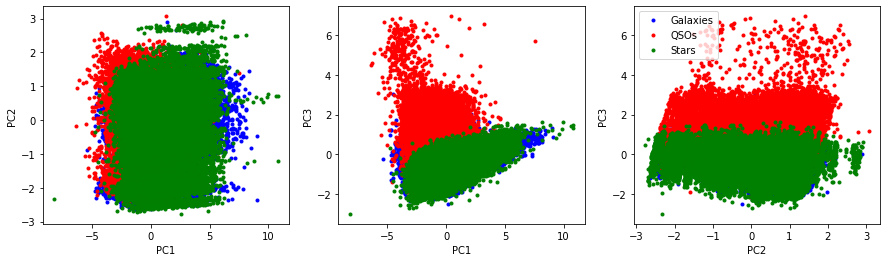

In [13]:
# 2D plots relating (PC1 and PC2), (PC1 and PC3) and (PC2 and PC3)

fig,((ax12,ax13,ax23))=plt.subplots(1,3,figsize=(15,4))

# PC1 vs PC2
## Galaxies
ax12.plot(X_pca_cleaned[pca_df['class']=='GALAXY'][:,0],
           X_pca_cleaned[pca_df['class']=='GALAXY'][:,1], '.b')
## QSOs
ax12.plot(X_pca_cleaned[pca_df['class']=='QSO'][:,0],
           X_pca_cleaned[pca_df['class']=='QSO'][:,1], '.r')
## Stars
ax12.plot(X_pca_cleaned[pca_df['class']=='STAR'][:,0],
           X_pca_cleaned[pca_df['class']=='STAR'][:,1], '.g')
ax12.set_xlabel('PC1')
ax12.set_ylabel('PC2')

# PC1 and PC3
## Galaxies
ax13.plot(X_pca_cleaned[pca_df['class']=='GALAXY'][:,0],
           X_pca_cleaned[pca_df['class']=='GALAXY'][:,2], '.b')
## QSOs
ax13.plot(X_pca_cleaned[pca_df['class']=='QSO'][:,0],
           X_pca_cleaned[pca_df['class']=='QSO'][:,2], '.r')
## Stars
ax13.plot(X_pca_cleaned[pca_df['class']=='STAR'][:,0],
           X_pca_cleaned[pca_df['class']=='STAR'][:,2], '.g')
ax13.set_xlabel('PC1')
ax13.set_ylabel('PC3')

# PC2 and PC3
## Galaxies
ax23.plot(X_pca_cleaned[pca_df['class']=='GALAXY'][:,1],
           X_pca_cleaned[pca_df['class']=='GALAXY'][:,2], '.b',label='Galaxies')
## QSOs
ax23.plot(X_pca_cleaned[pca_df['class']=='QSO'][:,1],
           X_pca_cleaned[pca_df['class']=='QSO'][:,2], '.r',label='QSOs')
## Stars
ax23.plot(X_pca_cleaned[pca_df['class']=='STAR'][:,1],
           X_pca_cleaned[pca_df['class']=='STAR'][:,2], '.g',label='Stars')
ax23.set_xlabel('PC2')
ax23.set_ylabel('PC3')

ax23.legend()

#plt.savefig('images/PCA_2D_classes.png')

In [14]:
# Apply K-Means assuming 3 subsets

kmeans3=KMeans(n_clusters=3)
labels_km3=kmeans3.fit(X_pca_cleaned).labels_
print(np.unique(labels_km3))
print(len(labels_km3))


[0 1 2]
99999


In [15]:
# We analyze the fraction of objects in each cluster

pca_df['KMLabel']=labels_km3

f_star_0=100*sum((pca_df['class']=='STAR') & (pca_df['KMLabel']==0))/sum(pca_df['class']=='STAR')
f_star_1=100*sum((pca_df['class']=='STAR') & (pca_df['KMLabel']==1))/sum(pca_df['class']=='STAR')
f_star_2=100*sum((pca_df['class']=='STAR') & (pca_df['KMLabel']==2))/sum(pca_df['class']=='STAR')

f_galaxy_0=100*sum((pca_df['class']=='GALAXY') & (pca_df['KMLabel']==0))/sum(pca_df['class']=='GALAXY')
f_galaxy_1=100*sum((pca_df['class']=='GALAXY') & (pca_df['KMLabel']==1))/sum(pca_df['class']=='GALAXY')
f_galaxy_2=100*sum((pca_df['class']=='GALAXY') & (pca_df['KMLabel']==2))/sum(pca_df['class']=='GALAXY')

f_qso_0=100*sum((pca_df['class']=='QSO') & (pca_df['KMLabel']==0))/sum(pca_df['class']=='QSO')
f_qso_1=100*sum((pca_df['class']=='QSO') & (pca_df['KMLabel']==1))/sum(pca_df['class']=='QSO')
f_qso_2=100*sum((pca_df['class']=='QSO') & (pca_df['KMLabel']==2))/sum(pca_df['class']=='QSO')



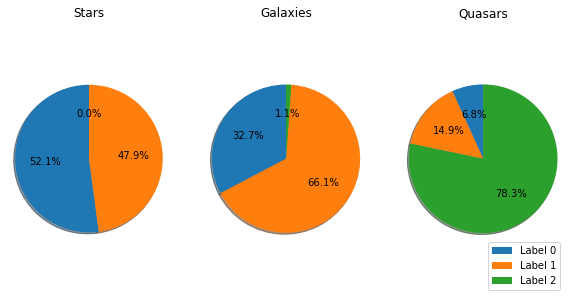

In [16]:
# Pie chart of the fraction of objects per cluster

fig,((ax1,ax2,ax3))=plt.subplots(1,3,figsize=(10,5))
labels='Label 0','Label 1','Label 2'

ax1.pie([f_star_0,f_star_1,f_star_2],shadow=True,startangle=90,autopct='%1.1f%%')
ax1.axis('equal')
ax1.set_title('Stars')

ax2.pie([f_galaxy_0,f_galaxy_1,f_galaxy_2],shadow=True,startangle=90,autopct='%1.1f%%')
ax2.axis('equal')
ax2.set_title('Galaxies')

ax3.pie([f_qso_0,f_qso_1,f_qso_2],shadow=True,startangle=90,autopct='%1.1f%%')
ax3.axis('equal')
ax3.set_title('Quasars')

ax3.legend(labels,loc='lower right')

#fig.savefig('pie_charts_kmeans.png')
plt.show()

Interestly, it seems that only 2 classes are well resolved by the clustering: galaxies and quasars. From the plots of the PCs, we can understand what is happening: there's no clear distinction between the points representing stars and galaxies.

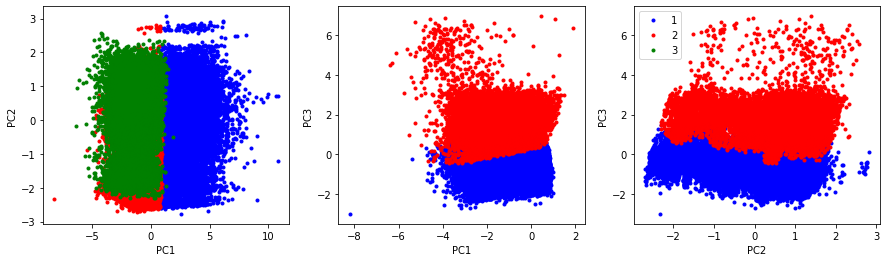

In [17]:
# 2D plots of points related to PC1, PC2 and PC3 divided by colors according to the k-means classification

fig,((ax12,ax13,ax23))=plt.subplots(1,3,figsize=(15,4))

# PC1 vs PC2
## Label 1
ax12.plot(X_pca_cleaned[labels_km3==0][:,0],
           X_pca_cleaned[labels_km3==0][:,1], '.b')
## Label 2
ax12.plot(X_pca_cleaned[labels_km3==1][:,0],
           X_pca_cleaned[labels_km3==1][:,1], '.r')
## Label 3
ax12.plot(X_pca_cleaned[labels_km3==2][:,0],
           X_pca_cleaned[labels_km3==2][:,1], '.g')
ax12.set_xlabel('PC1')
ax12.set_ylabel('PC2')

# PC1 vs PC3
## Label 1
ax13.plot(X_pca_cleaned[labels_km3==1][:,0],
           X_pca_cleaned[labels_km3==1][:,2], '.b')
## Label 2
ax13.plot(X_pca_cleaned[labels_km3==2][:,0],
           X_pca_cleaned[labels_km3==2][:,2], '.r')
## Label 3
ax13.plot(X_pca_cleaned[labels_km3==3][:,0],
           X_pca_cleaned[labels_km3==3][:,2], '.g')
ax13.set_xlabel('PC1')
ax13.set_ylabel('PC3')

# PC2 vs PC3
## Label 1
ax23.plot(X_pca_cleaned[labels_km3==1][:,1],
           X_pca_cleaned[labels_km3==1][:,2], '.b',label='1')
## Label 2
ax23.plot(X_pca_cleaned[labels_km3==2][:,1],
           X_pca_cleaned[labels_km3==2][:,2], '.r',label='2')
## Label 3
ax23.plot(X_pca_cleaned[labels_km3==3][:,1],
           X_pca_cleaned[labels_km3==3][:,2], '.g',label='3')
ax23.set_xlabel('PC2')
ax23.set_ylabel('PC3')

ax23.legend()

#plt.savefig('PCA_2D_clusters.png')

In [18]:
#Silhouette score test for different numbers of clusters

from sklearn.metrics import silhouette_score

K = range(2, 8)
fits = []
score = []

for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k).fit(X_pca_cleaned)
    
    # append the model to fits
    fits.append(model)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(X_pca_cleaned, model.labels_, metric='euclidean'))



In [19]:
# Plot silhouette score vs. number of clusters

plt.plot(K,score,label='K-Means')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.savefig('scores_kmeans.png')